Import Package

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import kagglehub
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load Dataset

In [ ]:
path = kagglehub.dataset_download("odins0n/ucf-crime-dataset")
print("Dataset downloaded at:", path)

data_dir = os.path.join(path, "Train")

  0%|          | 15.0M/11.0G [00:16<3:32:18, 927kB/s] 


KeyboardInterrupt: 

Konfigurasi ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 232 images belonging to 2 classes.
Found 57 images belonging to 2 classes.


Visualisasi beberapa contoh gambar dari dataset

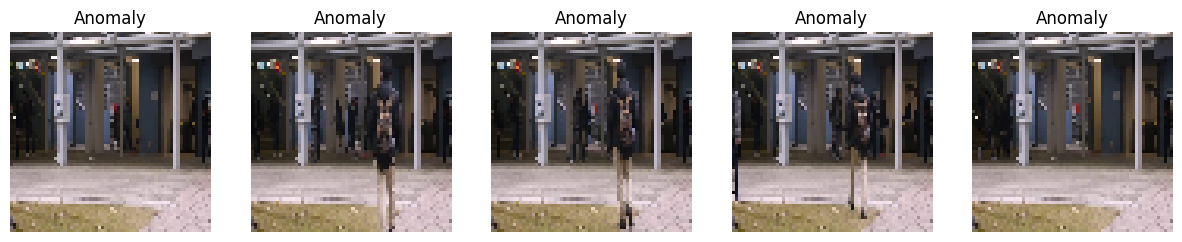

In [ ]:
sample_images, sample_labels = next(train_generator)
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(sample_images[i])
    axes[i].set_title(f"Class {np.argmax(sample_labels[i])}")
    axes[i].axis("off")
plt.show()

Model CNN untuk deteksi anomali multiclass

In [ ]:
def build_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(14, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Model

In [ ]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=10)

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 535ms/step - accuracy: 0.4174 - loss: 1.1011 - val_accuracy: 0.4737 - val_loss: 0.6874
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.5723 - loss: 0.6829 - val_accuracy: 0.9825 - val_loss: 0.6779
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.5916 - loss: 0.6678 - val_accuracy: 0.5263 - val_loss: 0.6513
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.6760 - loss: 0.6364 - val_accuracy: 0.9825 - val_loss: 0.6001
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.8033 - loss: 0.5779 - val_accuracy: 0.9825 - val_loss: 0.4988
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.9094 - loss: 0.4561 - val_accuracy: 0.9825 - val_loss: 0.3495
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9860 - loss: 0.2771 - val_accuracy: 0.9825 - val_loss: 0.1893
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9866 - loss: 0.1578 - val_accuracy: 0.9825 - val_loss:

Simpan model ke dalam file .h5

In [ ]:
model_path = "../model/anomaly_detection_model.h5"
model.save(model_path)

Visualisasi hasil training

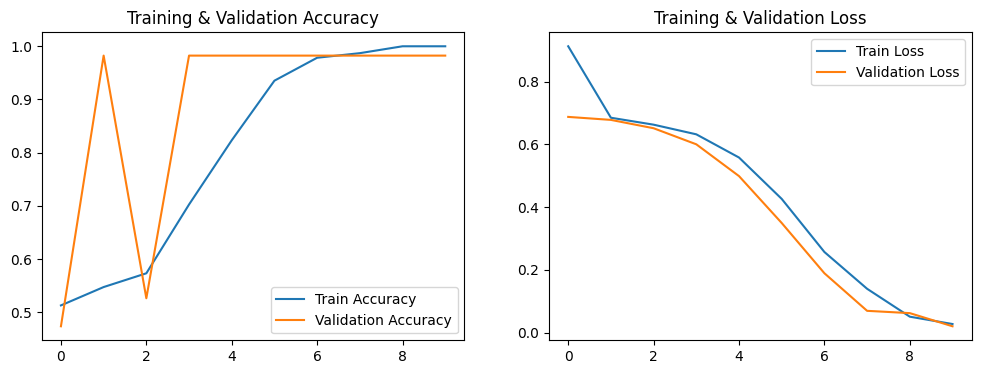

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training & Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

Fungsi uji Model pada Gambar

In [ ]:
def test_model(image_path):
    model = load_model(model_path)

    image = cv2.imread(image_path)
    image = cv2.resize(image, (64, 64))
    image = image / 255.0
    input_image = np.expand_dims(image, axis=0) 

    prediction = model.predict(input_image)[0]
    label_index = np.argmax(prediction)
    label_mapping = train_generator.class_indices
    label_name = list(label_mapping.keys())[label_index]

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediksi: {label_name}")
    plt.axis("off")
    plt.show()

Pengujian dengan Gambar

In [ ]:
test_image_path = os.path.join(path, "Test", "some_test_image.jpg")
test_model(test_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━